## Pendulum: One-step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/KEQL-main/source')

In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader import *
from loss import *
from utils import *

import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

In [4]:
model = 'pendulum'

### Cost function

Create `Kphiphi` to find the regularizer `R`

In [5]:
# Create Kphiphi
X = x_train_all.flatten()
sigma_K = jnp.mean(jnp.array([0.24994344, 0.74908123, 0.74908123]))
Kphiphi = Kphiphi_assembly( X[:N] , k = 'Gaussian', k_param = 0.5)

In [6]:
# Tr(Kphiphi)
trK = jnp.trace(Kphiphi[0:N,0:N])
# Tr(D^1D^1 Kphiphi)
trDDK = jnp.trace(Kphiphi[N:2*N,N:2*N])
# Tr(D^2D^2 Kphiphi)
trD2D2K = jnp.trace(Kphiphi[2*N:3*N,2*N:3*N])
# First block
ones = jnp.ones((N))
# Second block
second = ones*trDDK/trK
# Third block
third = ones*trD2D2K/trK
# Assemble R or take the diagonal or Kphiphi
diagonal = jnp.concatenate((ones,second,third))
R = jnp.diag(diagonal)

Create objective function `L`

In [7]:
def L(Z, X, U, f, R, lmbd):
    """Cost function for one step method.
    
    Args:
        Z: Vector of optimization variables in the cost function. 2*m*N
        X: List of mN points of dimension d.
        U: List of mN values of functions u^(1),...u^(N).
        f: List of mN values of functions u^(1),...u^(N).
        R: Matrix that regularizes Kphiphi
    Returns:
        scalar: a cost of this solution.    
    """ 
   
    ### First term

    # Build S_N
    S1 = jnp.vstack([X,U]).T
    S = jnp.hstack([S1,Z])

    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    
    # Gamma(S_N,S_N)
    sigma_Gamma = 1.35 # From 2-step
    Gamma = K(Gaussian, S, S, sigma_Gamma)
    alpha_Gamma = 1.1e-7 # nugget from 2-step !!!
    Gamma = Gamma + alpha_Gamma*jnp.eye(jnp.size(Gamma,0)) 
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    L1 = jnp.dot(f.T , b)
    #print("L1(Z_warm) = ", L1)


    ### Second term

    L2 = 0.

    sigma_K = jnp.mean(jnp.array([0.24994344, 0.74908123, 0.74908123])) # From 2-step
    Kphiphi = Kphiphi_assembly( X[:N] , k = 'Gaussian',k_param = sigma_K)
    alpha_K = 1e-6
    Kphiphi = Kphiphi + alpha_K*R 
    #print("cond(Kphiphi) = ", jnp.linalg.cond(Kphiphi))

    ZZ = jnp.hstack((U.reshape(-1,1),Z))
    for i in range(3):
        Z_i = jnp.reshape(ZZ[N*i:(i+1)*N,:].T,(N*3,1))
        c = jnp.linalg.solve(Kphiphi,Z_i)
        L2 += jnp.reshape(jnp.dot(Z_i.T , c),())

    #print("L2(Z_warm) = ",L2)

    return L1 + lmbd*L2 # Return loss.

#### Gradient descent

Training data

In [8]:
# First column in Gamma(S_N,S_N)
X = x_train_all.flatten() # N*m * 1

# Second column in Gamma(S_N,S_N)
U = u_train.T.reshape(N*m,) # N*m * 1

# f(X_N)
f = f_Train(model)

Initial guess: `Z_warm`

In [9]:
# Load gradients from 2-step
u_x_pred_train  = np.load('data/u_x_pred_train.npy')
u_xx_pred_train = np.load('data/u_xx_pred_train.npy')
# Build Z_warm
Z_warm = np.hstack([u_x_pred_train.T.reshape(N*m,1),u_xx_pred_train.T.reshape(N*m,1)])

In [10]:
L(Z_warm, X, U, f, R, lmbd = 1)

Array(271222.63776435, dtype=float64)

Which `lmbd` in the expression `L1 + lmbd*L2` should I use if `L1` >> `L2` ?

In [11]:
lmbd = jnp.power(2,np.linspace(-20,0,20))
losses = []
for l in lmbd:
    loss = L(Z_warm, X, U, f,R,l)
    losses.append(loss)
idx_min = losses.index(min(losses))
lmbd_min = lmbd[idx_min]

In [12]:
lmbd_min = 1 # It always picks the smallest here 

Initialize the grad functions with `jit` to be efficient

In [13]:
grad_Z = jit(grad(L, argnums=0))

# Run once to trigger JIT compilation.
grad_Z(Z_warm, X, U, f,R,lmbd= lmbd_min)
# Warm start here !!!

Array([[   8793.34141904,   -8261.10827973],
       [ -91072.07169462,  124093.89859382],
       [  74606.42443438, -111886.22208828],
       [   4961.08664115,    8348.92734708],
       [ -14715.5902543 ,  -10497.09129369],
       [  51640.83294222,   32614.70463237],
       [ -65301.03865168,  -33526.94710578],
       [  20441.81177178,   10605.16327173],
       [   -872.2694738 ,    -867.09143969],
       [  -1825.63680868,     817.31414033],
       [ 310239.94185723,  255831.12229606],
       [-302041.76526417, -294379.19958912],
       [-340078.77226192, -339253.47755807],
       [ 520574.47985463,  651069.43223057],
       [ 180785.2375418 ,  270376.23487543],
       [-115962.78556385, -184883.49447996],
       [-191115.38601073, -312123.11498672],
       [-273392.29936078, -467002.76631727],
       [ 259515.39286148,  508176.68090151],
       [ -42089.87260339,  -97018.98501202],
       [  90052.3242545 ,   11491.37429838],
       [-210627.69357737,  -22896.50105046],
       [-1

Run the gradient descent for `100` epochs

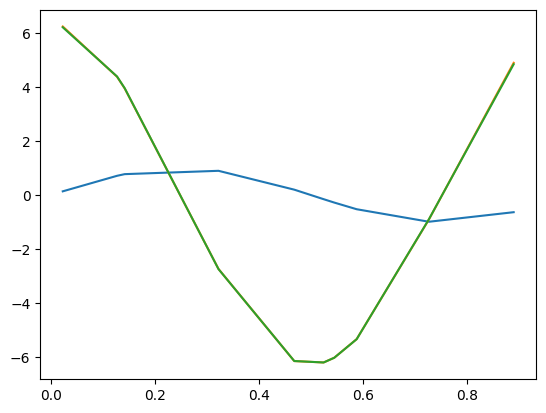

In [14]:
plt.plot(x_train, U[0:N])
plt.plot(x_train, u_x_pred_train[0:N,0])
plt.plot(x_train, u_x_train[:,0])
plt.show()

### Gradient descent

In [15]:
# Only do this for the first time - 
Z = np.copy(Z_warm)
#Z = np.load('data/Z.npy')

In [16]:
# If trained previously use Z
if np.all(Z != Z_warm):
    Z = np.load('data/Z.npy')
else:
    Z = np.copy(Z_warm)
learning_rate = 1e-3
for i in range(300):
    delta_Z = grad_Z(Z, X, U, f,R,lmbd=lmbd_min)
    lr = jnp.linalg.norm(Z)/jnp.linalg.norm(delta_Z)*learning_rate
    Z -= lr * delta_Z
    if i % 10 == 0:
        print(L(Z, X, U, f, R, lmbd=lmbd_min))
    
# Save at the end of iterations
np.save('data/Z.npy',Z)

171505.63966242032
105372.92210885465
97645.5645234986
92782.80432532798
88006.34422751452
82812.39022920576
77006.87713616193
70414.70683513948
62884.430905952395
54982.897027269784
47366.12459907838
41341.55092546567
41209.9353755252
39397.25214959885
37885.51717773946
38356.69985233729
38079.29207572641
36181.28164058788
38016.346339134725
37628.73785473682
36918.3283587163
37497.56163309772
37092.76383344794
37804.223549479386
37154.707918151085
35452.985111564805
37149.39539565179
36782.58708589377
35638.16823902543
36919.37753967518


## Evaluation of `Z`

In [20]:
# Load true gradients from 2-step
u_x_train = np.load('data/u_x_train.npy')
u_xx_train = np.load('data/u_xx_train.npy')
# Build true Z
Z_true = np.hstack([u_x_train.T.reshape(N*m,1),u_xx_train.T.reshape(N*m,1)])

> One-step Method vs Truth

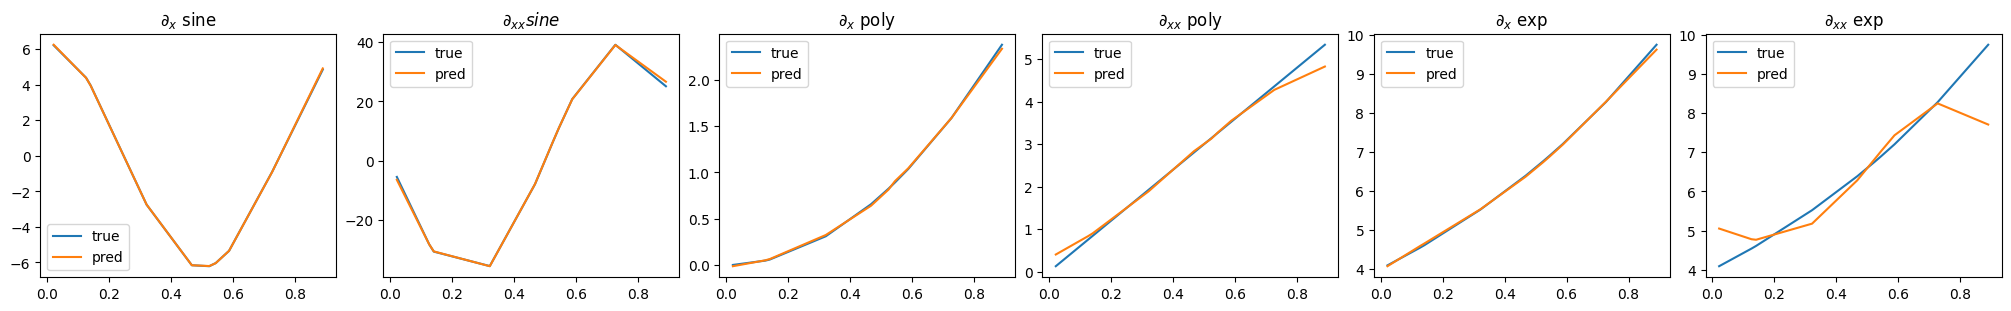

In [21]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train,Z_true[0:N,0],label ='true')
ax1.plot(x_train,Z[0:N,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train,Z_true[0:N,1],label ='true')
ax2.plot(x_train,Z[0:N,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train,Z_true[N:2*N,0],label ='true')
ax3.plot(x_train,Z[N:2*N,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train,Z_true[N:2*N,1],label ='true')
ax4.plot(x_train,Z[N:2*N,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train,Z_true[2*N:3*N,0],label ='true')
ax5.plot(x_train,Z[2*N:3*N,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train,Z_true[2*N:3*N,1],label ='true')
ax6.plot(x_train,Z[2*N:3*N,1],label ='pred')
ax6.legend()
plt.show()

> Two-step Method vs Truth

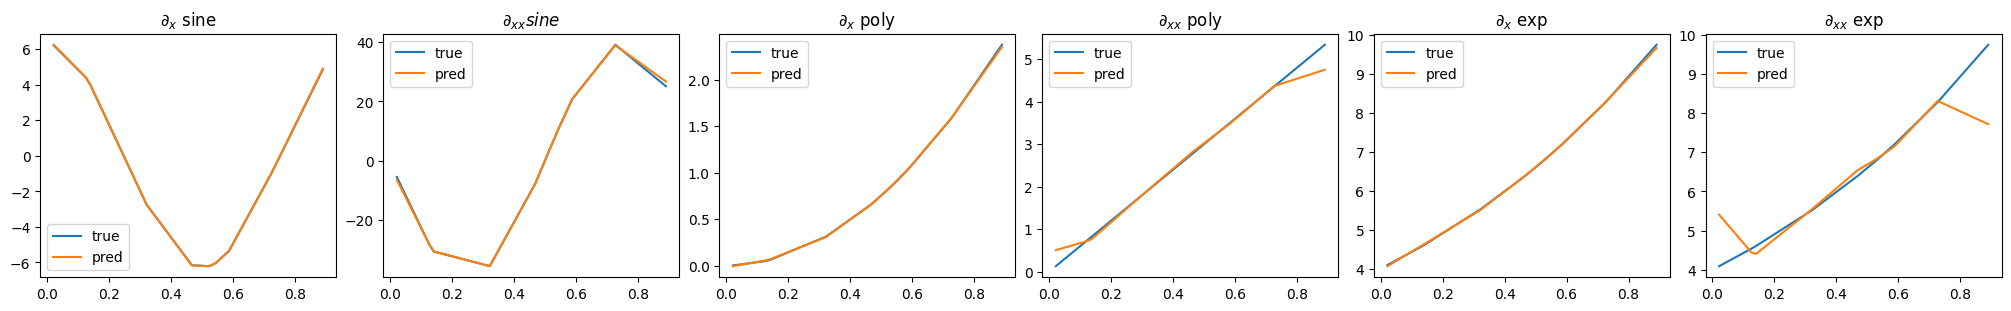

In [22]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train,Z_true[0:N,0],label ='true')
ax1.plot(x_train,Z_warm[0:N,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train,Z_true[0:N,1],label ='true')
ax2.plot(x_train,Z_warm[0:N,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train,Z_true[N:2*N,0],label ='true')
ax3.plot(x_train,Z_warm[N:2*N,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train,Z_true[N:2*N,1],label ='true')
ax4.plot(x_train,Z_warm[N:2*N,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train,Z_true[2*N:3*N,0],label ='true')
ax5.plot(x_train,Z_warm[2*N:3*N,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train,Z_true[2*N:3*N,1],label ='true')
ax6.plot(x_train,Z_warm[2*N:3*N,1],label ='pred')
ax6.legend()
plt.show()